# Illustration: Sampling algorithms

In this notebook, we address the problem of sampling from a probability distribution  

$$f(x) \propto \exp\big(-R(x)\big),$$

where $R(x)$ denotes the Rosenbrock function. The Rosenbrock function, originally introduced as a test problem for optimization methods, is characterized by its narrow curved valley, which poses significant challenges for both optimization and sampling algorithms. Our objective is to explore this distribution in different underlying spaces $\mathbb{R}^2$, $\mathbb{R}^3$, $\mathbb{S}^1$ and $\mathbb{S}^2$. Sampling from such a distribution is non-trivial due to the complex geometry of the Rosenbrock landscape, particularly when constrained to manifolds. To tackle this problem, we will employ and compare two widely used Monte Carlo sampling algorithms:  

1. **Metropolis–Hastings (MH):**  
   A Markov Chain Monte Carlo (MCMC) method based on proposing candidate samples and accepting them with a probability that ensures detailed balance.  

2. **Hamiltonian Monte Carlo (HMC):**  
   An advanced MCMC method that leverages Hamiltonian dynamics to generate proposals, allowing for more efficient exploration of high-dimensional or geometrically complex probability distributions.  

Through this study, we aim to:  
- Illustrate the challenges posed by the Rosenbrock function across different spaces.  
- Evaluate the performance and efficiency of MH and HMC in sampling from $f(x)$.  
- Provide visual insights into the sampled distributions and their relationship to the geometry of the underlying space.  


We are going to use the following libraries:


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from tqdm import tqdm
import pandas as pd
import plotly.express as px
import time

: 

The Rosenbrock function is a classical test function widely used in optimization and sampling problems due to its challenging landscape. It is defined in $d$ dimensions as  

$R(x) = \sum_{i=1}^{d-1} [ (a - x_i)^2 + b (x_{i+1} - x_i^2)^2]$

where $x = (x_1, x_2, \dots, x_d) \in \mathbb{R}^d$ and parameters $a$ and $b$ (commonly set to $a = 1$ and $b = 100$).

The Rosenbrock function has a unique global minimum located at  $x^\ast = (a, a^2, a^4, \dots, a^{2^{d-1}}),$ with the corresponding function value $f(x^\ast) = 0$.  

In [2]:
def rosenbrock(x, a=1.0, b=5.0, d=None):
    """
    Rosenbrock function in d dimensions.
    """
    x = np.atleast_2d(x) 
    if d is None:
        d = x.shape[1]
    if d < 2:
        raise ValueError("d >= 2")
    total = np.zeros(x.shape[0])
    for i in range(d - 1):
        xi = x[:, i]
        xnext = x[:, i + 1]
        total += (a - xi)**2 + b * (xnext - xi**2)**2
    return total if x.shape[0] > 1 else total[0]


def rosenbrock_grad(x, a=1.0, b=5.0, d=None):
    """
    Gradient of the Rosenbrock function in d dimensions.
    """
    x = np.atleast_2d(x)
    if d is None:
        d = x.shape[1]
    if d < 2:
        raise ValueError("d >= 2")
        
    grad = np.zeros_like(x)

    # j = 0
    grad[:, 0] = -2*(a - x[:, 0]) - 4*b*x[:, 0]*(x[:, 1] - x[:, 0]**2)

    # 0 < j < d-1
    for j in range(1, d-1):
        grad[:, j] = (-2*(a - x[:, j])
                      + 2*b*(x[:, j] - x[:, j-1]**2)
                      - 4*b*x[:, j]*(x[:, j+1] - x[:, j]**2))

    # j = d-1
    grad[:, d-1] = 2*b*(x[:, d-1] - x[:, d-2]**2)
    grad = grad if x.shape[0] > 1 else grad[0]
    return np.clip(grad, -1e7, 1e7)


The figure below shows the Rosenbrock function in $\mathbb{R}^2$ using contour lines, showing the minima in the spaces $\mathbb{R}^2$ and $\mathbb{S}^1$.

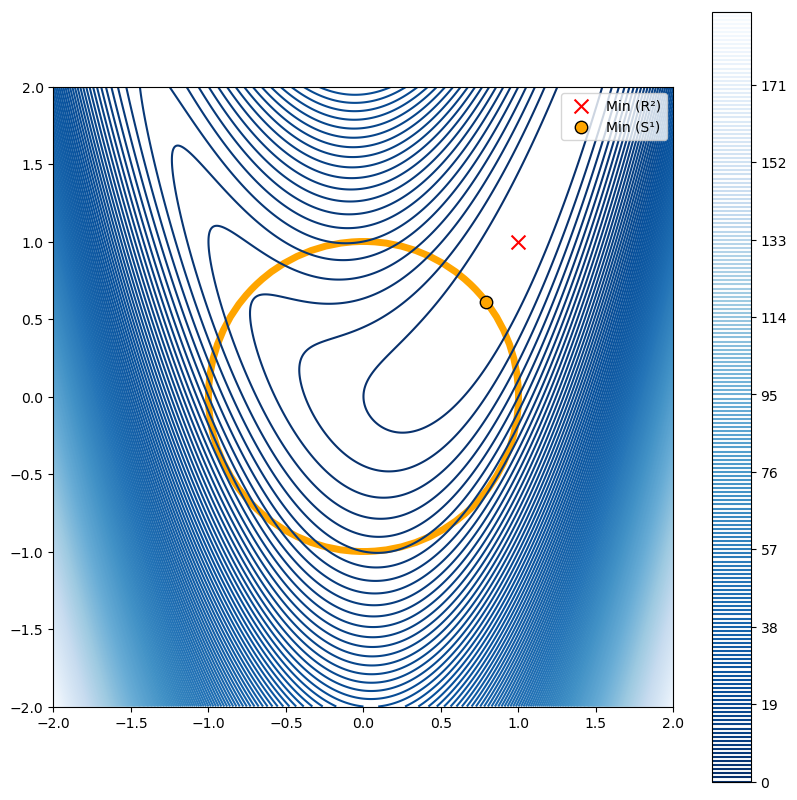

In [3]:


x_lin = np.linspace(-2, 2, 1500)
y_lin = np.linspace(-2, 2, 1500)
X, Y = np.meshgrid(x_lin, y_lin)
points_R2 = np.stack([X.ravel(), Y.ravel()], axis=1)
Z = rosenbrock(points_R2, d=2).reshape(X.shape)
min_R2 = (1.0, 1.0)
n_points = 2500
theta = np.linspace(0, 2*np.pi, n_points, endpoint=False)
x_S1 = np.cos(theta)
y_S1 = np.sin(theta)
vals_S1 = rosenbrock(np.stack([x_S1, y_S1], axis=1), d=2)
min_idx_S1 = np.argmin(vals_S1)
min_S1 = (x_S1[min_idx_S1], y_S1[min_idx_S1])
fig, ax = plt.subplots(figsize=(10,10))
contour = ax.contour(X, Y, Z, levels=200, cmap='Blues_r')
fig.colorbar(contour, ax=ax)
ax.scatter(*min_R2, color='red', marker='x', s=100, label="Min (R²)")
circle = plt.Circle((0,0), 1.0, color='orange', fill=False, linewidth=5, label="")
ax.add_patch(circle)
ax.scatter(*min_S1, color='orange', marker='o', s=80, edgecolor='black', label="Min (S¹)")
ax.set_aspect('equal')
ax.legend(loc="upper right")

plt.show()
del x_lin, y_lin, X, Y, points_R2, Z, min_R2, n_points
del theta, x_S1, y_S1, vals_S1, min_idx_S1, min_S1
del fig, ax, contour, circle

## Buiding functions

In [4]:
# Sampling from von Mises Fisher distribution

def _random_VMF_cos(d, kappa, n):
    """
    Generate n iid samples of cos(theta) from the marginal density:
    p(t) ∝ (1 - t^2)^{(d-2)/2} * exp(kappa * t)
    using the algorithm of Ulrich (1984) / Wood (1994).
    """
    if kappa == 0:
        # Uniform case
        return 2 * np.random.rand(n) - 1
    
    b = (d - 1) / (2 * kappa + np.sqrt(4 * kappa**2 + (d - 1)**2))
    x0 = (1 - b) / (1 + b)
    c = kappa * x0 + (d - 1) * np.log(1 - x0**2)

    samples = []
    while len(samples) < n:
        m = int((n - len(samples)) * 1.5)
        z = np.random.beta((d - 1) / 2, (d - 1) / 2, size=m)
        t = (1 - (1 + b) * z) / (1 - (1 - b) * z)
        u = np.random.uniform(size=m)
        accept = kappa * t + (d - 1) * np.log(1 - x0 * t) - c >= np.log(u)
        samples.extend(t[accept])
    return np.array(samples[:n])


def random_VMF(mu, kappa, size=None):
    """
    Von Mises-Fisher sampler on S^{d-1} in R^d
    Parameters:
        mu: mean direction (array of shape (d,))
        kappa: concentration parameter (float >= 0)
        size: number of samples (int or tuple)
    Returns:
        Samples on the unit sphere in R^d
    """
    mu = np.asarray(mu)
    mu = mu / np.linalg.norm(mu)
    d = mu.shape[0]

    if d == 1:
        return mu[0] * (2*np.random.binomial(n=1, p=expit(kappa), size=(size,1))-1)

    if size is None:
        n = 1
        shape = ()
    else:
        n = np.prod(size)
        shape = size if isinstance(size, tuple) else (size,)

    # Sample cos(theta)
    cos_theta = _random_VMF_cos(d, kappa, n)
    sin_theta = np.sqrt(1 - cos_theta**2)

    # Sample uniformly in the orthogonal complement of mu
    v = np.random.randn(n, d)
    proj = v - (v @ mu)[:, None] * mu
    proj_norm = np.linalg.norm(proj, axis=1, keepdims=True)
    proj_unit = proj / proj_norm

    # Combine to get samples on sphere
    samples = cos_theta[:, None] * mu + sin_theta[:, None] * proj_unit
    return samples.reshape((*shape, d))


In [5]:
#Trace convergence

def gelman_rubin_rhat(chains):
    m, n = chains.shape
    chain_means = np.mean(chains, axis=1)
    chain_vars = np.var(chains, axis=1, ddof=1)
    
    B = n * np.var(chain_means, ddof=1)
    W = np.mean(chain_vars)
    var_hat = ( (n - 1)/n ) * W + (1/n) * B
    R_hat = np.sqrt(var_hat / W)
    return R_hat

def effective_sample_size(chains, max_lag=1000):
    m, n = chains.shape
    mean_chain = np.mean(chains)
    var_chain = np.var(chains, ddof=1)
    autocorr_sum = 0.0
    for lag in range(1, max_lag):
        acov_lag = 0.0
        for chain in chains:
            acov = np.cov(chain[:-lag], chain[lag:])[0, 1]
            acov_lag += acov
        acov_lag /= m
        rho = acov_lag / var_chain
        if rho <= 0: 
            break
        autocorr_sum += 2 * rho
    ess =   1 / (1 + autocorr_sum)
    return ess

In [6]:
def Rosenbrock_sampling(Conf, Sampler, Model): 
    start = time.perf_counter()
    print("="*80)   
    print(f"{Sampler} for {Model} estimation of Rosenbrock distribution")
    print("="*80)


    if Sampler == "MH": 
        min_ar, max_ar = 0.3, 0.5
        max_step = 5.0
    if Sampler == "HMC":
        min_ar, max_ar = 0.6, 0.8
        max_step = 1.0

    x0 = Conf['x0']
    d = x0.shape[0]
    n_samples = Conf['n_samples']
    step = Conf['step']

    burn_in = Conf['burn_in']
    thin = Conf['thin']
    n_iterations = n_samples * thin + burn_in
    n_chains = Conf['n_chains']    

    mask = np.arange(burn_in, n_iterations, thin)

    print(f"Number of chains: {n_chains}")
    print(f"Samples of size {n_samples} with burn-in {burn_in} and thinning {thin}")
    print(f"Number of draws per chain: {n_iterations}")
    print(f"Initial step: {step:.4f}")


    if Model == "Euclidean":
        if Sampler == "MH": 
            def proposal(x_current, step):
                x_proposed = np.random.normal(loc=x_current, scale=step)
                proposed_dist = -rosenbrock(x_proposed)
                current_dist = -rosenbrock(x_current)
                return current_dist, proposed_dist, x_proposed
        if Sampler == "HMC":
            def proposal(x_current, step):
                L = np.clip(np.int16(1/step),1,250)
                x_proposed = x_current.copy()
                current_p_x = np.random.normal(0, step, size=x_current.shape)
                proposed_p_x = current_p_x.copy()
                for _ in range(L):
                        proposed_p_x += 0.5 * step * rosenbrock_grad(x_proposed) * (-1)
                        x_proposed += step * proposed_p_x
                        proposed_p_x += 0.5 * step * rosenbrock_grad(x_proposed) * (-1)
                proposed_dist = -rosenbrock(x_proposed) -  0.5 * np.sum(proposed_p_x**2) 
                current_dist = -rosenbrock(x_current)  -  0.5 * np.sum(current_p_x**2) 
                return current_dist, proposed_dist, x_proposed
            

    if Model == "Spherical":
        if Sampler == "MH": 
            def proposal(x_current, step):
                x_proposed = random_VMF(x_current, step, size=1)[0]
                proposed_dist = -rosenbrock(x_proposed)
                current_dist = -rosenbrock(x_current)
                return current_dist, proposed_dist, x_proposed
        if Sampler == "HMC": #GHMC
            def project_to_tangent_space(theta, phi):
                return phi - np.dot(phi, theta) * theta
            def geodesic_flow(theta, phi, step_size):
                alpha = np.linalg.norm(phi)
                if alpha > 1e-10:
                    new_theta = theta * np.cos(alpha * step_size) + (phi / alpha) * np.sin(alpha * step_size)
                    new_phi = phi * np.cos(alpha * step_size) - alpha * theta * np.sin(alpha * step_size)
                else:
                    new_theta, new_phi = theta, phi 
                return new_theta, new_phi
            def proposal(x_current, step):
                L = np.clip(np.int16(1/step),1,250)
                current_p_x = np.random.normal(0, 1, size=x_current.shape)
                x_proposed = x_current.copy()
                proposed_p_x = current_p_x.copy()
                proposed_p_x = project_to_tangent_space(x_proposed, proposed_p_x) 
                for _ in range(L):
                        proposed_p_x -= 0.5 * step * rosenbrock_grad(x_proposed) * (-1)
                        proposed_p_x = project_to_tangent_space(x_proposed, proposed_p_x) 
                        x_proposed, proposed_p_x = geodesic_flow(x_proposed, proposed_p_x, step)
                        proposed_p_x -= 0.5 * step * rosenbrock_grad(x_proposed) * (-1)
                proposed_dist = -rosenbrock(x_proposed) -  0.5 * np.sum(proposed_p_x**2) 
                current_dist = -rosenbrock(x_current)  -  0.5 * np.sum(current_p_x**2) 
                return current_dist, proposed_dist, x_proposed

    results_per_chain = []
    avg_step = 0.0
    for chain in range(n_chains):
        step = Conf['step']
        x_current = x0.copy()
        x_chain = np.zeros((n_iterations,d))
        acceptance_rate_trace_x = np.zeros(n_iterations)
        dist_chain = np.zeros(n_iterations)
        accept_count_x = 0
        total_updates_x = 0
        current_dist = -rosenbrock(x_current)       

        print("*"*32 + f"\nChain {chain}\n" + "*"*32)
        for i in tqdm(range(n_iterations), desc="Sampling progress", unit=" draws"):
            current_dist, proposed_dist, x_proposed = proposal(x_current, step)
            log_r = proposed_dist - current_dist
            if np.log(np.random.rand()) < log_r:
                x_current = x_proposed 
                current_dist = proposed_dist
                accept_count_x += 1
            total_updates_x += 1
            # Chain update
            x_chain[i] = x_current.copy()
            acceptance_rate_trace_x[i] = accept_count_x / total_updates_x if total_updates_x > 0 else 0
            # Diagnostics update  
            dist_chain[i] = current_dist
            # Tunning proposals
            if 0 < i < burn_in:
                acc_rate_x = acceptance_rate_trace_x[i]
                factor_x = 0.995 if acc_rate_x < min_ar else 1.005 if acc_rate_x > max_ar else 1.0
                step = np.clip(step * factor_x, 1e-5, max_step)
                
            if i == burn_in:
                print("-"*32 + "\nTuning complete\n" + "-"*32)
                print(f"Final step: {step:.4f}")     
        results =  {
            'samples': x_chain[mask],
            'acceptance_rate_trace': acceptance_rate_trace_x[mask],
            'dist_chain': dist_chain[mask], 
        }
        avg_step +=np.float64(step).copy()
        results_per_chain.append(results)
    avg_step /= n_chains

    print("*"*32 + f"\nTrace convergence\n" + "*"*32)
    samples_all = np.array([res['samples'] for res in results_per_chain])  
    diagnostics = {}
    for j in range(d):
        chains_dimj = samples_all[:, :, j]  
        rhat = gelman_rubin_rhat(chains_dimj)
        ess = effective_sample_size(chains_dimj)
        diagnostics[f"dim_{j+1}"] = {"Rhat": rhat, "rESS": ess}
        print(f"Dimension {j+1}: R-hat = {rhat:.4f}, rESS ≈ {ess:.6f}")

    print("*"*32)
    print("Execution completed")
    print("*"*32)
    samples_all = np.concatenate([res['samples'] for res in results_per_chain], axis=0)
    acc_all = np.concatenate([res['acceptance_rate_trace'] for res in results_per_chain], axis=0)
    dist_all = np.concatenate([res['dist_chain'] for res in results_per_chain], axis=0)

    end = time.perf_counter()
    elapsed = end - start

    return {
        "samples": samples_all,
        "acceptance_rate_trace": acc_all,
        "dist_chain": dist_all,
        "step": avg_step,
        "time": elapsed, 
        "diagnostics": diagnostics,
        "configuration": Conf, 
        "sampler": Sampler,
        "model": Model
    }

In [21]:
def visualizing_results(results):
    from IPython.display import clear_output
    clear_output(wait=True)
    
    samples = results['samples']
    d = samples.shape[1]
    aceptance_rate = results['acceptance_rate_trace']
    rosenbrock_chain = -results['dist_chain']
    time_elapsed = results['time']
    conf = results['configuration']
    diagnostics = results['diagnostics']
    sampler = results['sampler']
    model = results['model']

    # General information

    print("*"*80)
    print(f"{sampler} for {model} estimation of Rosenbrock distribution in dimension {d}")
    print(f"Samples of size {conf['n_samples']} with burn-in {conf['burn_in']} and thinning {conf['thin']}")
    print(f"Execution time: {time_elapsed:.4f} seconds")
    print(f"Overall aceptance rate: {np.mean(aceptance_rate):.4f}")
    print("Trace diagnostics")
    for key, value in diagnostics.items():
        print(f"   {key}: R-hat = {value['Rhat']:.4f}, rESS ≈ {value['rESS']:.4f}")
    print(f"Average step after tunning: {results['step']:.4f}")
    print("*"*80)
    
    # Visualize diagnostics

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(aceptance_rate, lw=1)
    axes[0].set_title(f"Acceptance rate over samples. Mean: {np.mean(aceptance_rate):.4f}")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Acceptance rate")
    axes[0].set_ylim(0,1)
    if sampler == "MH": min_ar, max_ar = 0.3, 0.5
    if sampler == "HMC": min_ar, max_ar = 0.6, 0.8
    axes[0].axhline(min_ar, color="red", linestyle="--", label="Objective interval")
    axes[0].axhline(max_ar, color="red", linestyle="--", label="")
    axes[1].scatter(range(len(rosenbrock_chain)), rosenbrock_chain, alpha=0.2, s=10, color='gray')
    mean_val = np.mean(rosenbrock_chain)
    low_val = np.percentile(rosenbrock_chain, 2.5)
    high_val = np.percentile(rosenbrock_chain, 97.5)
    axes[1].axhline(mean_val, color="red", linestyle="--", label=f"Mean = {mean_val:.4f}")
    axes[1].axhline(low_val, color="blue", linestyle="--", label=f"2.5% = {low_val:.4f}")
    axes[1].axhline(high_val, color="blue", linestyle="--", label=f"97.5% = {high_val:.4f}")
    axes[1].set_title("Rosenbrock chain over iterations")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Rosenbrock")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # Visualize distribution

    if d == 2 and model == "Euclidean":
        min_x = np.min(samples[:, 0])-0.5
        max_x = np.max(samples[:, 0])+0.5
        min_y = np.min(samples[:, 1])-0.5
        max_y = np.max(samples[:, 1])+0.5
        x = np.linspace(min_x, max_x, 1500)
        y = np.linspace(min_y, max_y, 1500)
        X, Y = np.meshgrid(x, y)
        points_R2 = np.stack([X.ravel(), Y.ravel()], axis=1)
        Z = rosenbrock(points_R2, d=2).reshape(X.shape)

        plt.figure(figsize=(10, 10))
        plt.contour(X, Y, Z, levels=200, cmap="Blues_r")
        plt.scatter(samples[:, 0], samples[:, 1], alpha=0.2, s=10, color="lightgray")
        plt.xlabel("")
        plt.ylabel("")
        plt.show()

    elif d == 2 and model == "Spherical":
        import matplotlib.ticker as ticker
        from fractions import Fraction
        theta = np.arctan2(samples[:,1], samples[:,0])
        theta = theta % (2 * np.pi)
        phi = np.linspace(0, 2*np.pi, 2000)
        x_circ = np.cos(phi)
        y_circ = np.sin(phi)
        points_R2 = np.stack([x_circ, y_circ], axis=1)       
        Z = rosenbrock(points_R2, d=2)   

        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10,10))
        sc = ax.scatter(phi, np.ones_like(phi), c=Z, cmap="Blues_r", s=8)
        counts, bins = np.histogram(theta, bins=200, range=(0, 2*np.pi))
        bin_centers = (bins[:-1] + bins[1:]) / 2
        r_hist = 0.5 * counts / counts.max()
        ax.bar(bin_centers, r_hist, width=2*np.pi/200, bottom=0.15, color="lightgray", edgecolor="none")
        ax.set_xticks(np.arange(0, 2*np.pi, np.pi/8))
        ax.set_theta_zero_location("E")
        ax.set_theta_direction(1)
        def custom_formatter(val, pos):
            val = val % (2 * np.pi)
            frac = Fraction(val / np.pi).limit_denominator(8)
            if np.isclose(val, 0) or np.isclose(val, 2*np.pi):
                return r"$0$"
            num, den = frac.numerator, frac.denominator
            if den == 1:
                return rf"${num}\pi$"
            elif num == 1:
                return rf"$\frac{{\pi}}{{{den}}}$"
            else:
                return rf"$\frac{{{num}\pi}}{{{den}}}$"
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
        cbar = fig.colorbar(sc, ax=ax, pad=0.08)
        cbar.ax.tick_params(labelsize=8)
        ax.grid(False)
        ax.set_yticklabels([])
        plt.show()

    elif d == 3 and model == "Euclidean":
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection="3d")
        Z = rosenbrock(samples, d=3)
        p = ax.scatter(
            samples[:,0], samples[:,1], samples[:,2],
            c=Z, cmap="Blues_r", alpha=0.2, s=10
        )
        fig.colorbar(p, ax=ax, shrink=0.6, aspect=15, pad=0.1, label="Rosenbrock value")
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_zlabel("")

        plt.show()


    elif d == 3 and model == "Spherical":
        import plotly.graph_objects as go
        u = np.linspace(0, 2*np.pi, 200)
        v = np.linspace(0, np.pi, 100)
        U, V = np.meshgrid(u, v)
        xs = np.cos(U) * np.sin(V)
        ys = np.sin(U) * np.sin(V)
        zs = np.cos(V)
        points_sphere = np.stack([xs.ravel(), ys.ravel(), zs.ravel()], axis=1)
        Z = rosenbrock(points_sphere, d=3).reshape(xs.shape)

        surface = go.Surface(
            x=xs, y=ys, z=zs, surfacecolor=Z,
            colorscale="Blues_r",
            colorbar=dict(title="Rosenbrock value"),
            showscale=True,
            opacity=0.9
        )
        scatter = go.Scatter3d(
            x=samples[:,0], y=samples[:,1], z=samples[:,2],
            mode="markers",
            marker=dict(size=2, color="lightgray", opacity=0.5),
            name="Samples"
        )

        fig = go.Figure(data=[surface, scatter])
        fig.update_layout(
            scene=dict(
                xaxis=dict(showbackground=False, showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showbackground=False, showgrid=False, zeroline=False, showticklabels=False),
                zaxis=dict(showbackground=False, showgrid=False, zeroline=False, showticklabels=False)
            ),
            margin=dict(l=0, r=0, b=0, t=0)
        )

        fig.show()
    
    # Traces 
    n_samples, d = samples.shape
    iterations = np.arange(1, n_samples + 1)

    for j in range(d):
        x = samples[:, j]
        mean_x = np.mean(x)
        quantiles_x = np.quantile(x, [0.025, 0.975])
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 4), constrained_layout=True)

        # --- Traceplot ---
        sns.scatterplot(
            x=iterations, y=x,
            color='black', alpha=0.3, s=10, ax=axes[0]
        )
        axes[0].axhline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
        axes[0].axhline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
        axes[0].axhline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
        axes[0].set_xlabel("Iteration")
        axes[0].set_ylabel(fr"$x_{{{j+1}}}$")
        axes[0].set_title(f"Markov Chain for dimension {j+1}")
        axes[0].legend()
        sns.despine(ax=axes[0])

        # --- Histogram ---
        sns.histplot(
            x, bins=120, kde=False, stat='density',
            color='gray', edgecolor='white', ax=axes[1]
        )
        axes[1].axvline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
        axes[1].axvline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
        axes[1].axvline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
        axes[1].set_xlabel(fr"$x_{{{j+1}}}$")
        axes[1].set_ylabel("Density")
        axes[1].set_title(f"Marginal distribution of dimension {j+1}")
        axes[1].legend()
        sns.despine(ax=axes[1])

        plt.show()



## Euclidean case

### Metropolis Hastings: Gaussian proposal

********************************************************************************
MH for Euclidean estimation of Rosenbrock distribution in dimension 2
Samples of size 5000 with burn-in 50000 and thinning 100
Execution time: 40.2300 seconds
Overall aceptance rate: 0.3634
Trace diagnostics
   dim_1: R-hat = 0.9999, rESS ≈ 0.2736
   dim_2: R-hat = 0.9999, rESS ≈ 0.1931
Average step after tunning: 0.4292
********************************************************************************


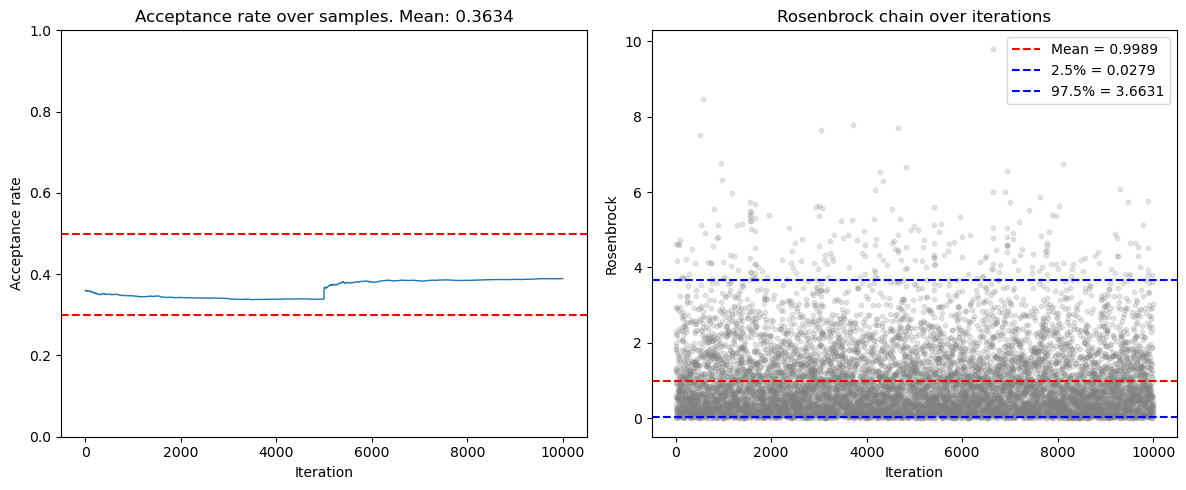

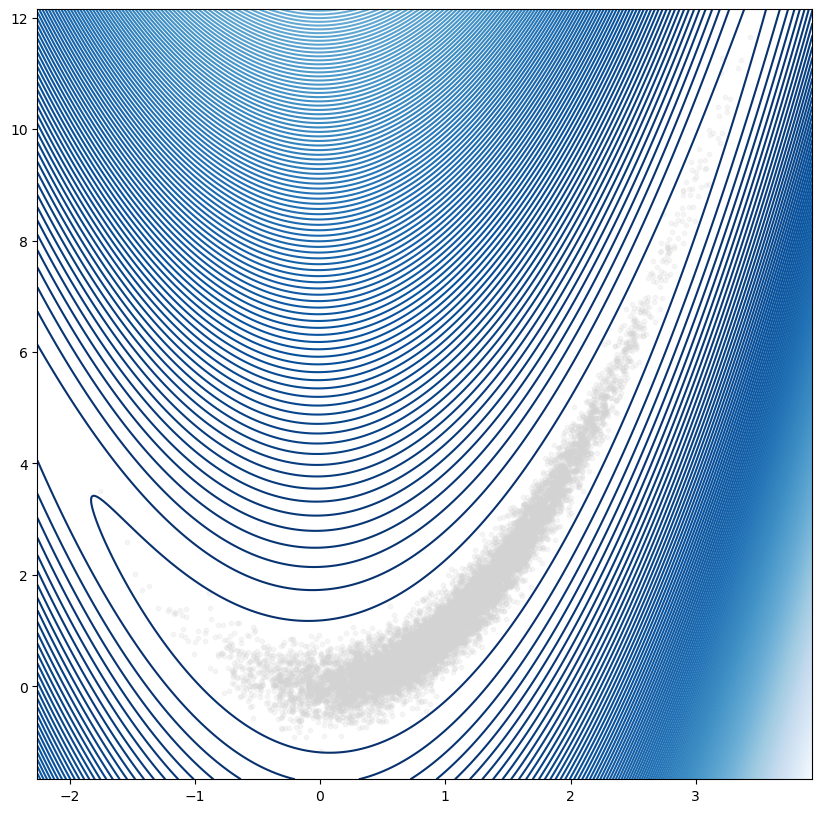

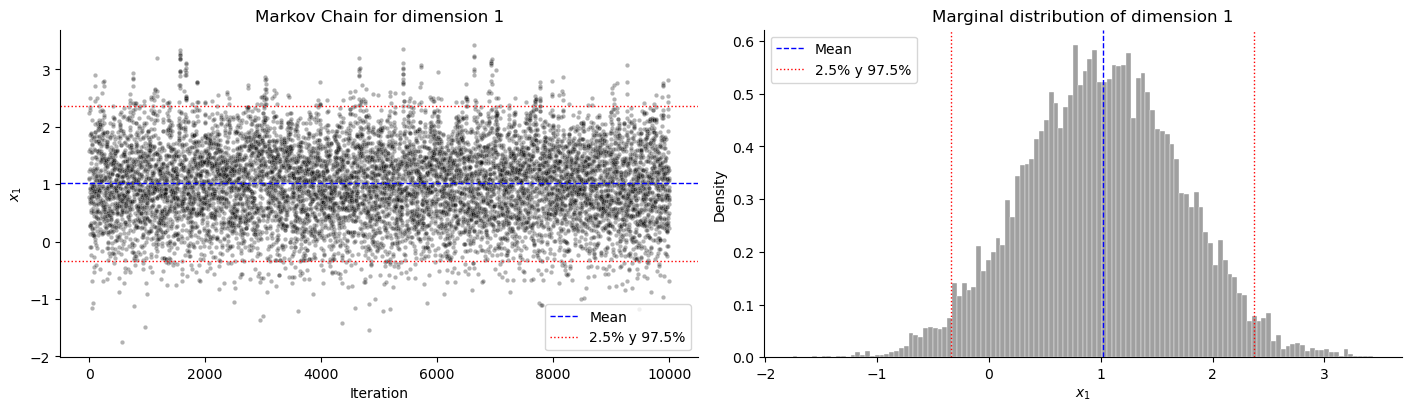

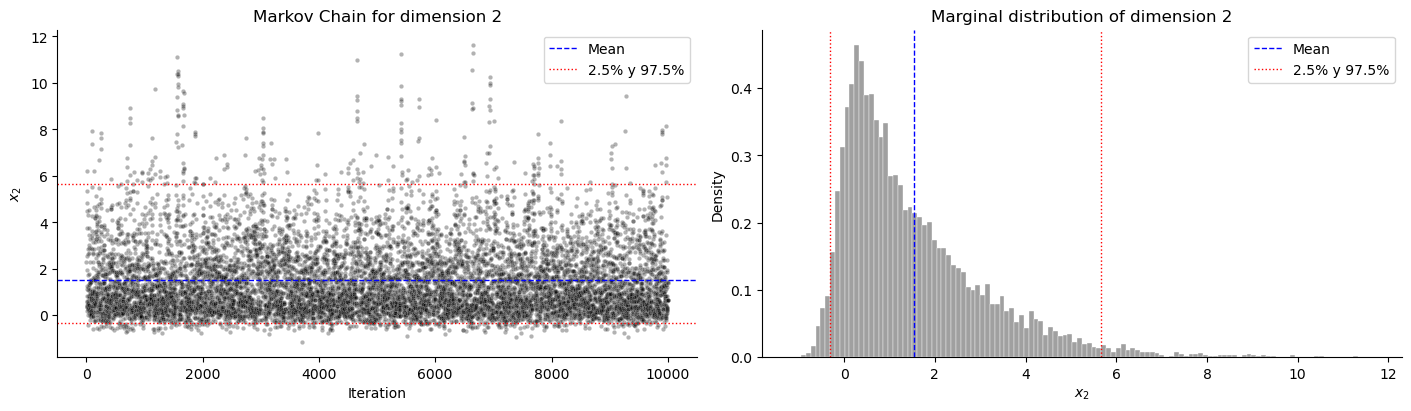

In [ ]:
Conf_R2_MH = {
    "x0": np.array([0.1, 0.0]),   
    "n_samples": 5000,            
    "step": 0.05,                 
    "burn_in": 50000,               
    "thin": 100,                    
    "n_chains": 2                  
}

results_R2_MH = Rosenbrock_sampling(Conf_R2_MH, Sampler="MH", Model="Euclidean")


visualizing_results(results_R2_MH)

Conf_R3_MH = {
    "x0": np.array([0.1, 0.0, 0.0]),   
    "n_samples": 5000,            
    "step": 0.05,                 
    "burn_in": 15000,               
    "thin": 10,                    
    "n_chains": 2                
}

results_R3_MH = Rosenbrock_sampling(Conf_R3_MH, Sampler="MH", Model="Euclidean")

visualizing_results(results_R3_MH)

### Hamiltonian Monte Carlo

********************************************************************************
HMC for Euclidean estimation of Rosenbrock distribution in dimension 2
Samples of size 5000 with burn-in 50000 and thinning 100
Execution time: 903.9240 seconds
Overall aceptance rate: 0.9340
Trace diagnostics
   dim_1: R-hat = 1.0003, rESS ≈ 1.0000
   dim_2: R-hat = 1.0001, rESS ≈ 1.0000
Average step after tunning: 0.1567
********************************************************************************


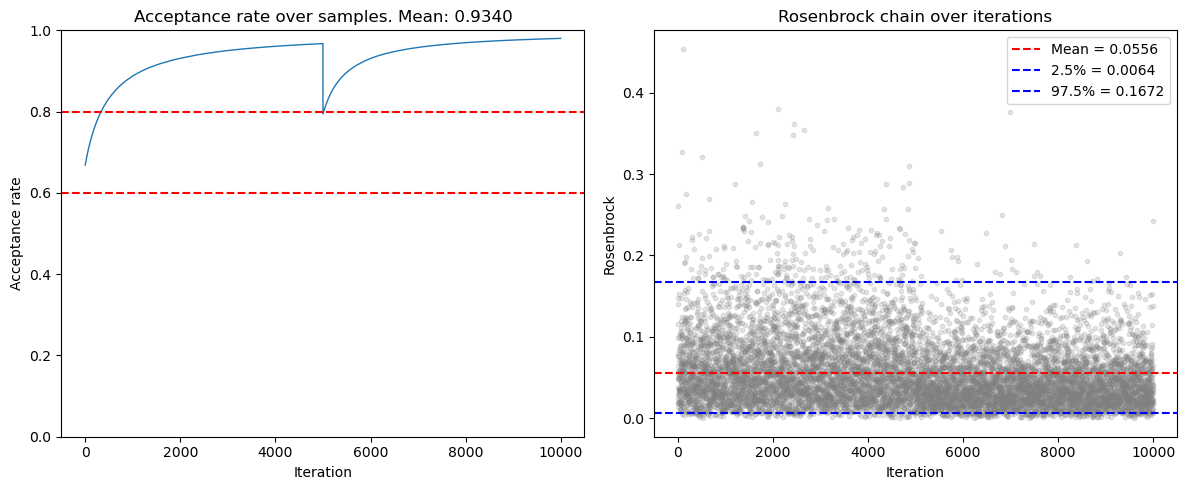

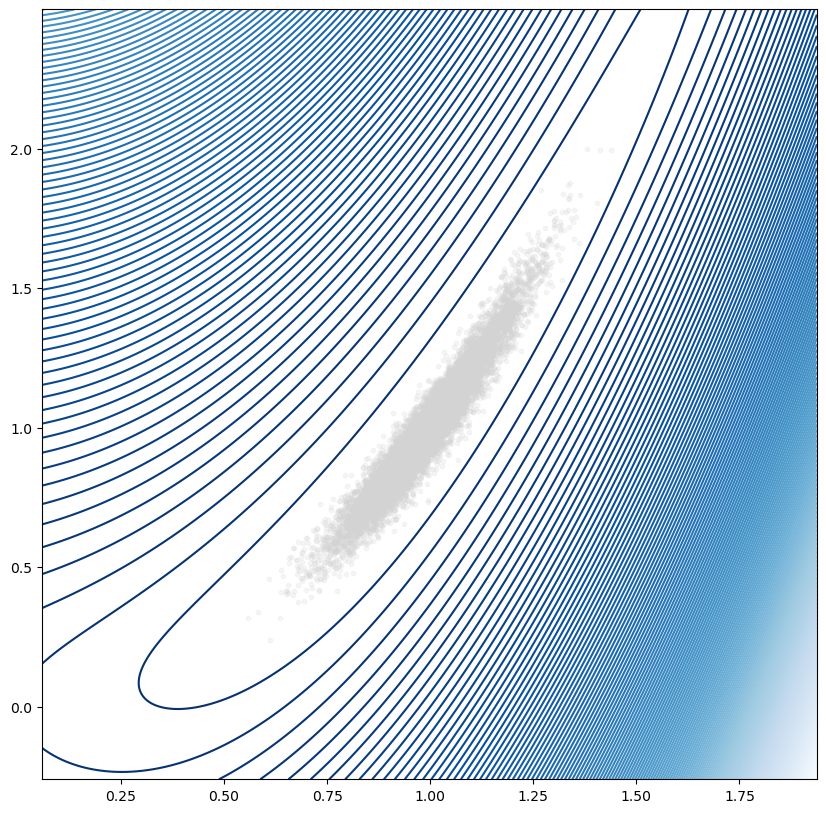

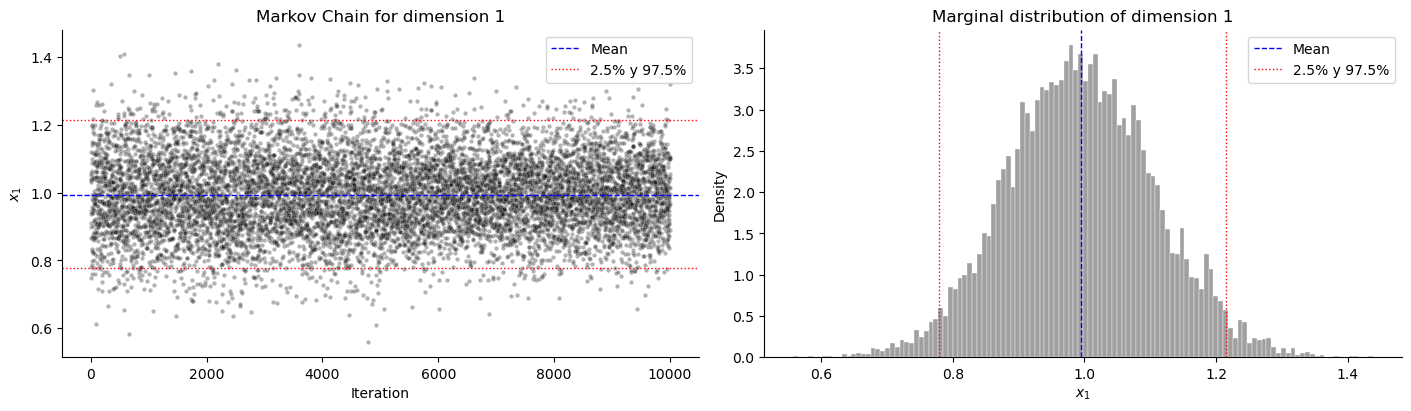

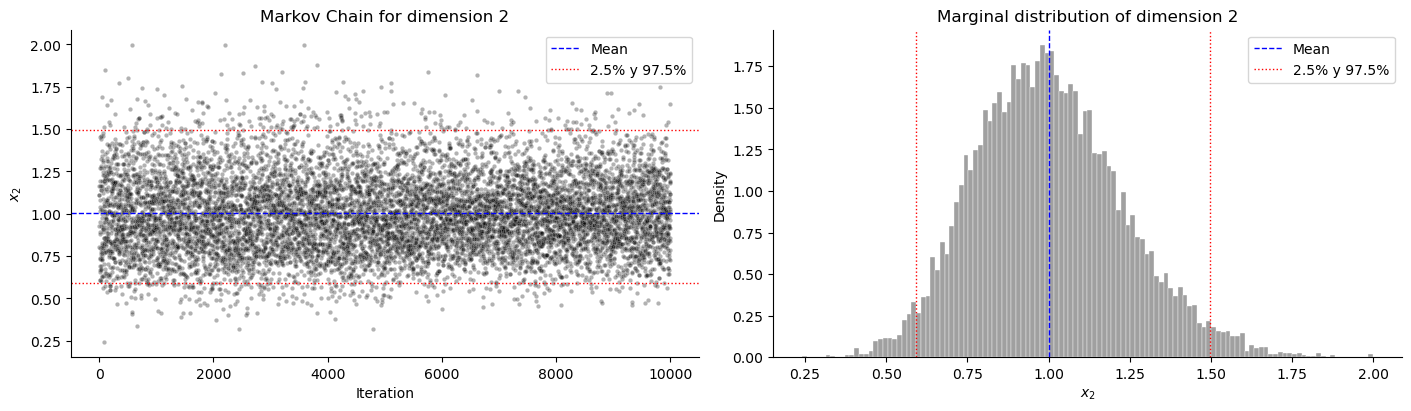

In [16]:
Conf_R2_HMC = {
    "x0": np.array([0.0, 0.0]),   
    "n_samples": 5000,            
    "step": 0.05,                 
    "burn_in": 50000,               
    "thin": 100,                    
    "n_chains": 2                   
}

results_R2_HMC = Rosenbrock_sampling(Conf_R2_HMC, Sampler="HMC", Model="Euclidean")

visualizing_results(results_R2_HMC)

Conf_R3_HMC = {
    "x0": np.array([0.1, 0.0]),   
    "n_samples": 5000,            
    "step": 0.05,                 
    "burn_in": 5000,               
    "thin": 1,                    
    "n_chains": 2                
}

results_R3_HMC = Rosenbrock_sampling(Conf_R3_HMC, Sampler="HMC", Model="Euclidean")

## Spherical case

### Metropolis Hastings: von Mises Fisher proposal

********************************************************************************
MH for Spherical estimation of Rosenbrock distribution in dimension 2
Samples of size 5000 with burn-in 50000 and thinning 100
Execution time: 98.2749 seconds
Overall aceptance rate: 0.1250
Trace diagnostics
   dim_1: R-hat = 1.0000, rESS ≈ 0.9657
   dim_2: R-hat = 0.9999, rESS ≈ 0.9425
Average step after tunning: 0.0000
********************************************************************************


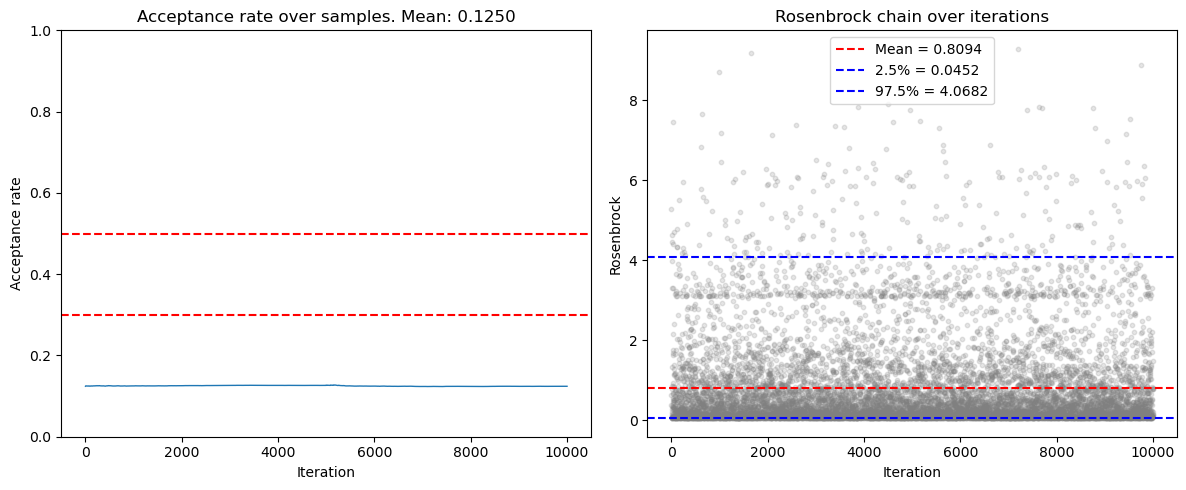

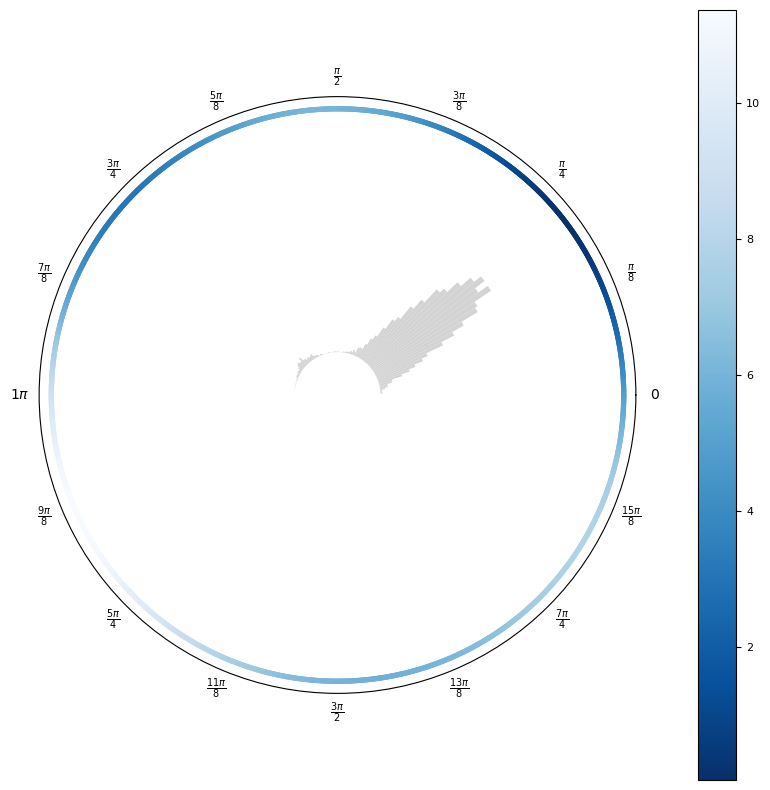

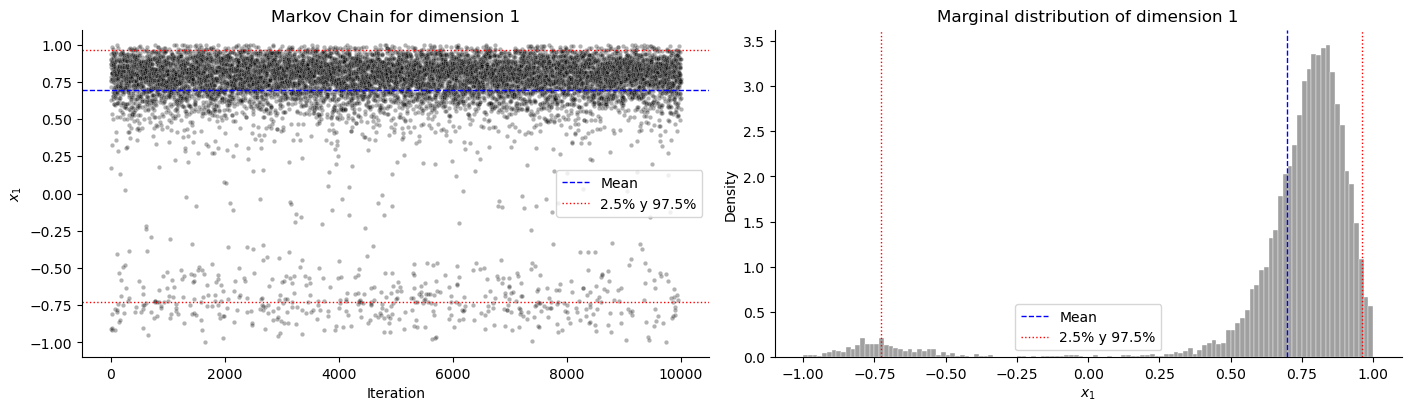

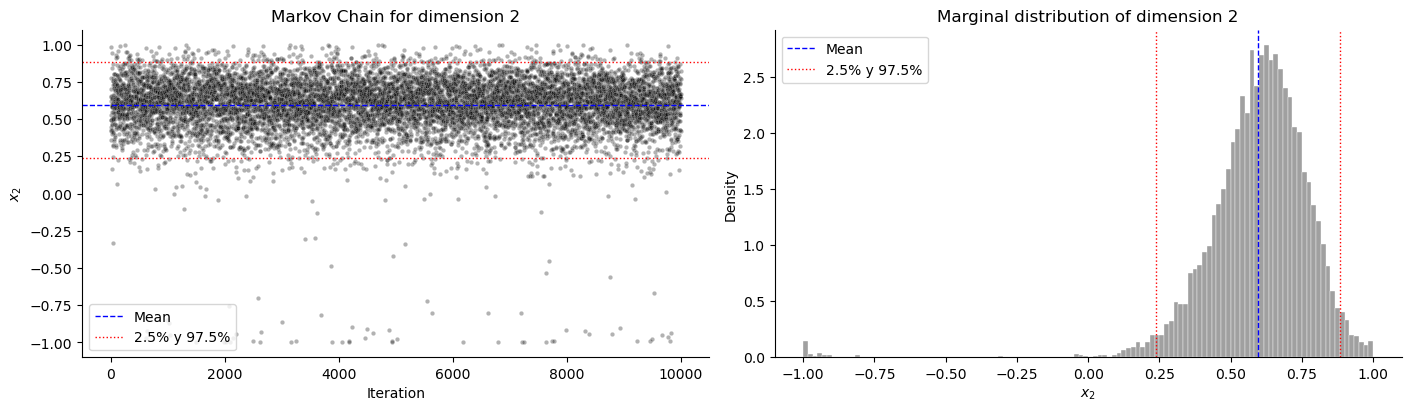

In [15]:
Conf_S1_MH = {
    "x0": np.array([1.0, 0.0]),   
    "n_samples": 5000,            
    "step": 0.05,                 
    "burn_in": 50000,               
    "thin": 100,                    
    "n_chains": 2                  
}

results_S1_MH = Rosenbrock_sampling(Conf_S1_MH, Sampler="MH", Model="Spherical")

visualizing_results(results_S1_MH)

Conf_S2_MH = {
    "x0": np.array([1.0, 0.0, 0.0]),   
    "n_samples": 20000,            
    "step": 0.05,                 
    "burn_in": 5000,               
    "thin": 1,                    
    "n_chains": 2                
}

results_S2_MH = Rosenbrock_sampling(Conf_S2_MH, Sampler="MH", Model="Spherical")

visualizing_results(results_S2_MH)

### Geodesic Hamiltonian Monte Carlo (GHMC)

********************************************************************************
HMC for Spherical estimation of Rosenbrock distribution in dimension 2
Samples of size 5000 with burn-in 50000 and thinning 5
Execution time: 12363.6318 seconds
Overall aceptance rate: 0.6819
Trace diagnostics
   dim_1: R-hat = 1.0993, rESS ≈ 0.0069
   dim_2: R-hat = 1.0012, rESS ≈ 0.0050
Average step after tunning: 0.0004
********************************************************************************


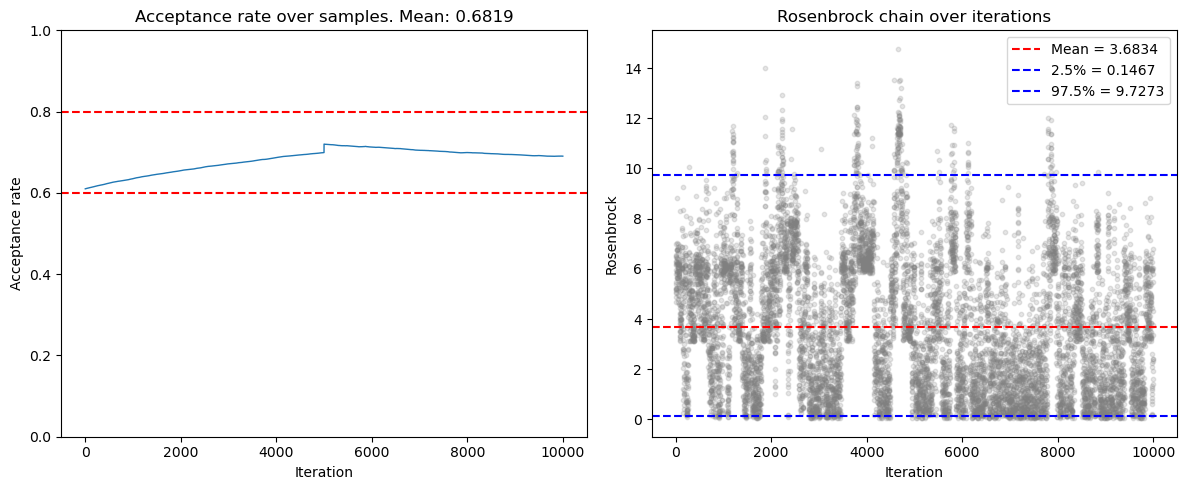

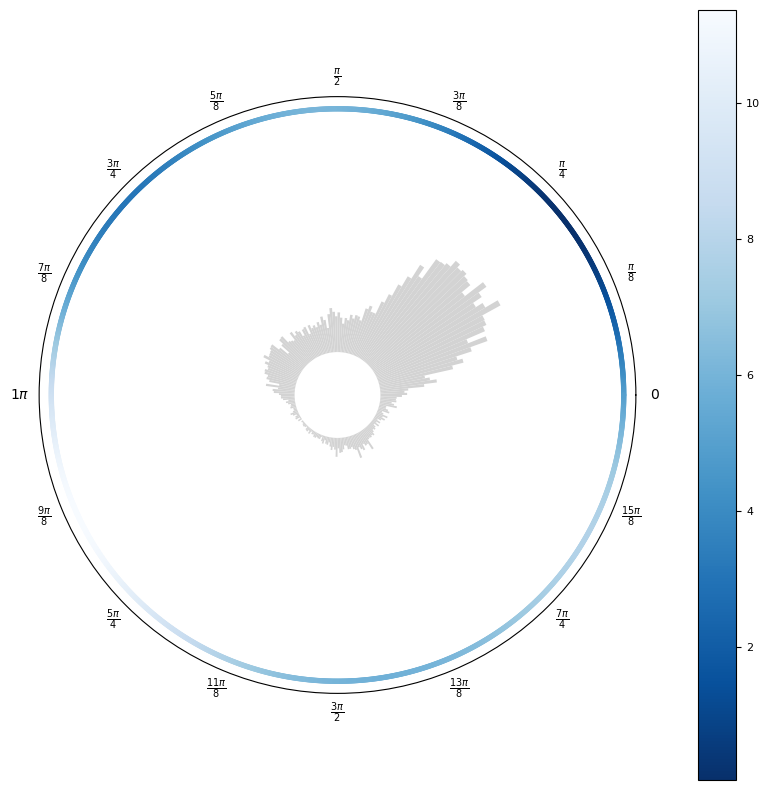

c:\Users\carlo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


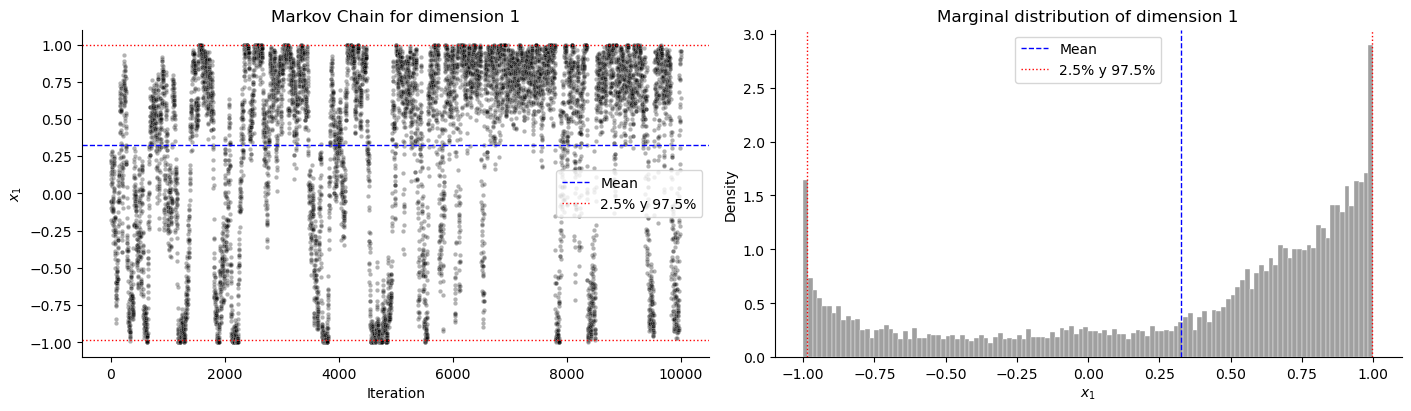

c:\Users\carlo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


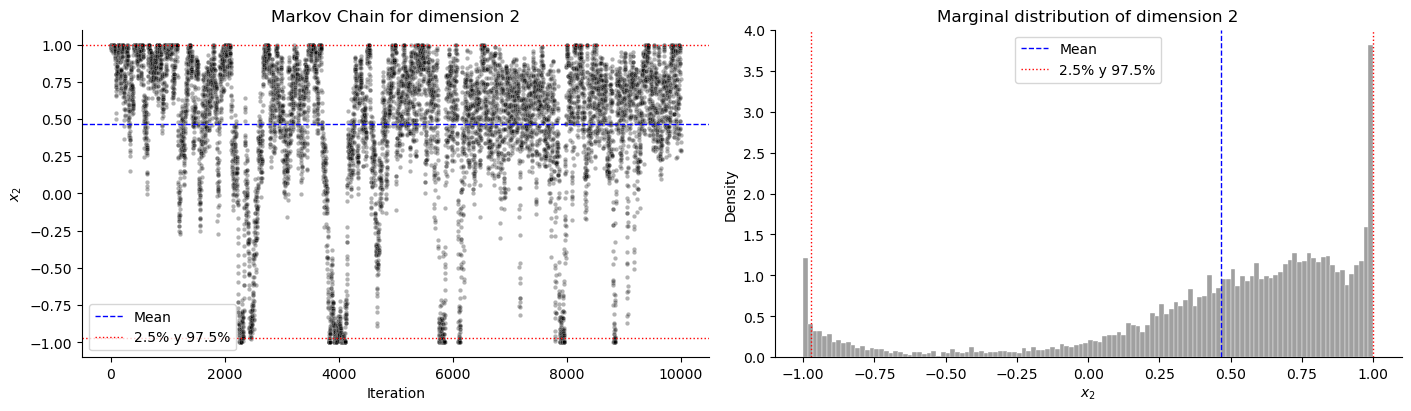

In [26]:
Conf_S1_HMC = {
    "x0": np.array([1.0, 0.0]),   
    "n_samples": 5000,            
    "step": 0.05,                 
    "burn_in": 50000,               
    "thin": 100,                    
    "n_chains": 2                
}

results_S1_HMC = Rosenbrock_sampling(Conf_S1_HMC, Sampler="HMC", Model="Spherical")

visualizing_results(results_S1_HMC)

Conf_S2_HMC = {
    "x0": np.array([1.0, 0.0, 0.0]),   
    "n_samples": 500,            
    "step": 0.05,                 
    "burn_in": 500,               
    "thin": 1,                    
    "n_chains": 2                
}

results_S2_HMC = Rosenbrock_sampling(Conf_S2_HMC, Sampler="HMC", Model="Spherical")

visualizing_results(results_S2_HMC)